# Homework 2
## ALCF AI for Science on Supercomputers
### Zachary Marks


# Introduction to Neural Networks
Author: Marieme Ngom, adapting materials from Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset.

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/mnist_task.png?raw=1"  align="left"/>



In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.8MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 316kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.91MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.51MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

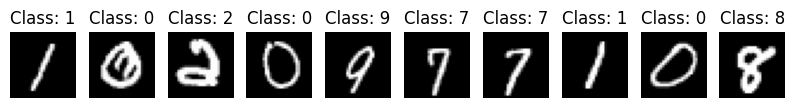

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression, like last week.
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication.

Note, like before, we consider multiple examples at once, adding another dimension to the input.


 <img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/LinearModel_1.png?raw=1"  align="center"/>



The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b). Last week, we used mean squared error (MSE), but this week let's make two changes that make more sense for classification:
    - Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
    - Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd), like last week. For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A learning rate. As we learned last week, the learning rate controls how far we move during each step.

In [6]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # First, we need to convert the input image to a vector by using
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()

        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)

    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [19]:
# RUN THIS CODE AGAIN TO CREATE A NEW MODEL INSTANCE; OTHERWISE TRAINING WILL CONTINUE FROM THE LAST EPOCH

linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.






In [8]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [9]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [12]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [20]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []

# ADDED CODE TO TRACK LOSS OVER EPOCHS
train_loss_all = []
val_loss_all = []



for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    train_loss_all.append(loss)

    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    val_loss_all.append(val_loss)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.5019797325134278, accuracy: 87.56666666666668
Epoch 0: val. loss: 0.4946895660238063, val. accuracy: 87.55833333333334
Epoch 1: training loss: 0.42167780554294587, accuracy: 88.99583333333332
Epoch 1: val. loss: 0.4126129321595456, val. accuracy: 88.725
Epoch 2: training loss: 0.3876915600299835, accuracy: 89.68125
Epoch 2: val. loss: 0.37798133381503696, val. accuracy: 89.525
Epoch 3: training loss: 0.36770800216992694, accuracy: 90.07083333333334
Epoch 3: val. loss: 0.3577792516097109, val. accuracy: 89.89166666666667
Epoch 4: training loss: 0.35411476929982505, accuracy: 90.41458333333333
Epoch 4: val. loss: 0.34417124520590964, val. accuracy: 90.25833333333333
CPU times: user 1min 12s, sys: 153 ms, total: 1min 13s
Wall time: 1min 13s


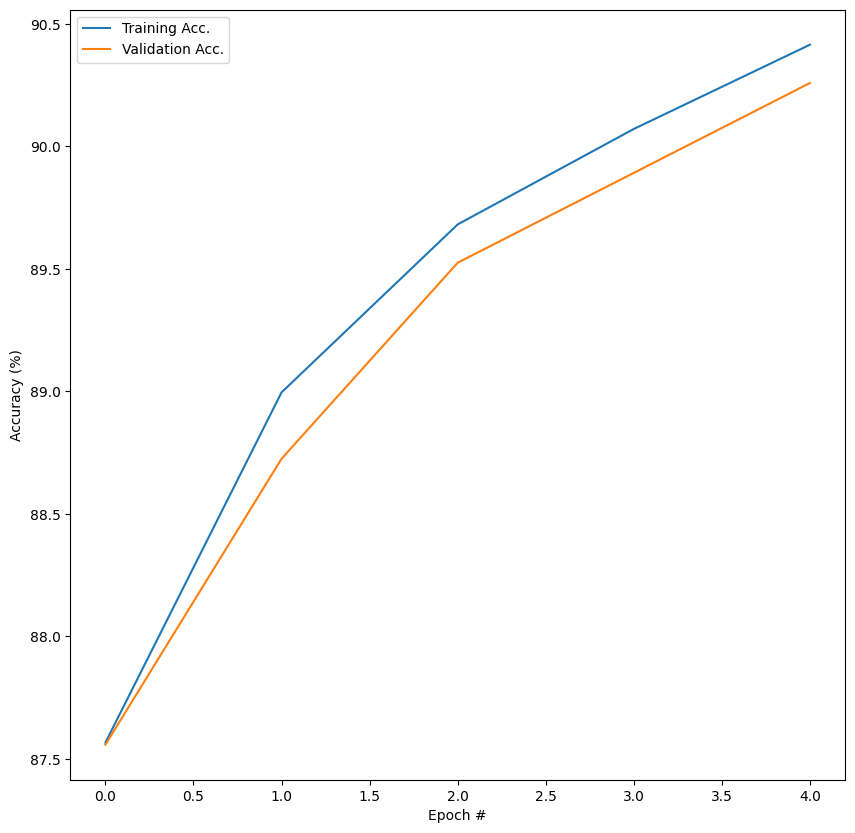

In [21]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy (%)')
plt.legend()

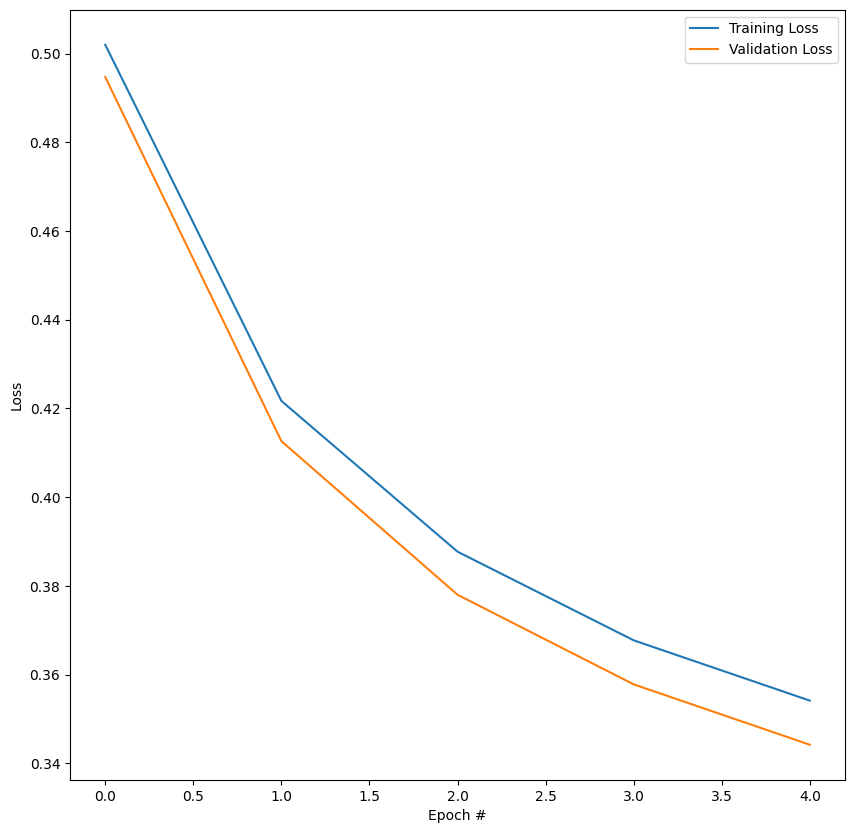

In [22]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_loss_all,label = 'Training Loss' )
plt.plot(range(epochs), val_loss_all, label = 'Validation Loss' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

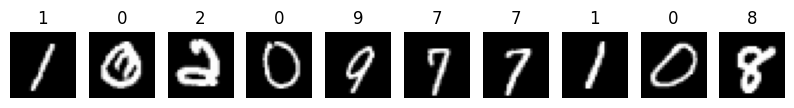

In [29]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval() # SETS MODEL TO EVALUATION MODE
# FROM RIGHT TO LEFT: CREATES AN ITERATOR OVER THE DATALOADER; GETS THE NEXT ITERATION, WHICH IS THE FIRST ONE; THIS IS A TUPLE OF (INPUTS, LABELS)
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0]) # GETS THE PREDICTIONS OF THE INPUTS FROM THE TUPLE `BATCH`

for i in range(10): # ITEMS 0-9
    plt.subplot(1,10,i+1)
    plt.axis('off')

    # `batch[0]` IS A TENSOR WITH SHAPE [batch_size, channels, height, width]; channel = 0 means the first channel, grayscale
    plt.imshow(batch[0][i,0,:,:], cmap="gray") # SELECTS ALL (:,:) OF THE PIXELS IN (HEIGHT, WIDTH) OF THE IMAGE
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc.

# Prediction

Let's see how our model generalizes to the unseen test data.



In [32]:
#For HW: cell to change batch size
#create dataloader for test data
# The dataloader makes our dataset iterable

batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [33]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.3325, test accuracy: 90.75%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [34]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])

    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Here are the first 10 images from the test data that this small model classified to a wrong class:



Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


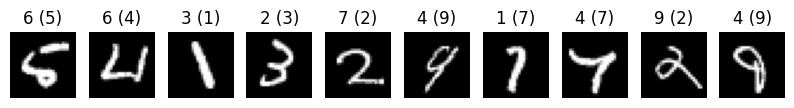

In [35]:
show_failures(linear_model, test_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/shallow_nn.png?raw=1"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/activation.jpeg?raw=1"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/deep_nn_annotated.jpg?raw=1"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/bias_vs_variance.png?raw=1"  align="left"/>


Vizualization wrt to the accuracy and loss (Image source: [Baeldung](https://www.baeldung.com/cs/ml-underfitting-overfitting)):
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/acc_under_over.webp?raw=1"  align="center"/>


To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
Vanishing gradients: Gradients become small as they propagate backward through the layers. Squashing activation functions like sigmoid or tanh could cause this.

Exploding gradients: Gradients grow exponentially usually due to "poor" weight initialization.

<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [36]:
#For HW: cell to change activation
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

#### Must run cell again below to create new nonlinear_model object to not just train from the end of the last one

In [37]:
#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [38]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.8063595547676087, accuracy: 78.15208333333334
Epoch 0: val. loss: 0.7978875250258344, val. accuracy: 77.875
Epoch 1: training loss: 0.38671597417195636, accuracy: 89.17291666666667
Epoch 1: val. loss: 0.37745976923628055, val. accuracy: 89.18333333333334
Epoch 2: training loss: 0.29705823558568956, accuracy: 91.51666666666667
Epoch 2: val. loss: 0.2896179013112758, val. accuracy: 91.08333333333334
Epoch 3: training loss: 0.24534531434377035, accuracy: 92.95
Epoch 3: val. loss: 0.24156672721530528, val. accuracy: 92.72500000000001
Epoch 4: training loss: 0.210998916387558, accuracy: 93.875
Epoch 4: val. loss: 0.21142749527984478, val. accuracy: 93.55
CPU times: user 1min 19s, sys: 216 ms, total: 1min 20s
Wall time: 1min 25s


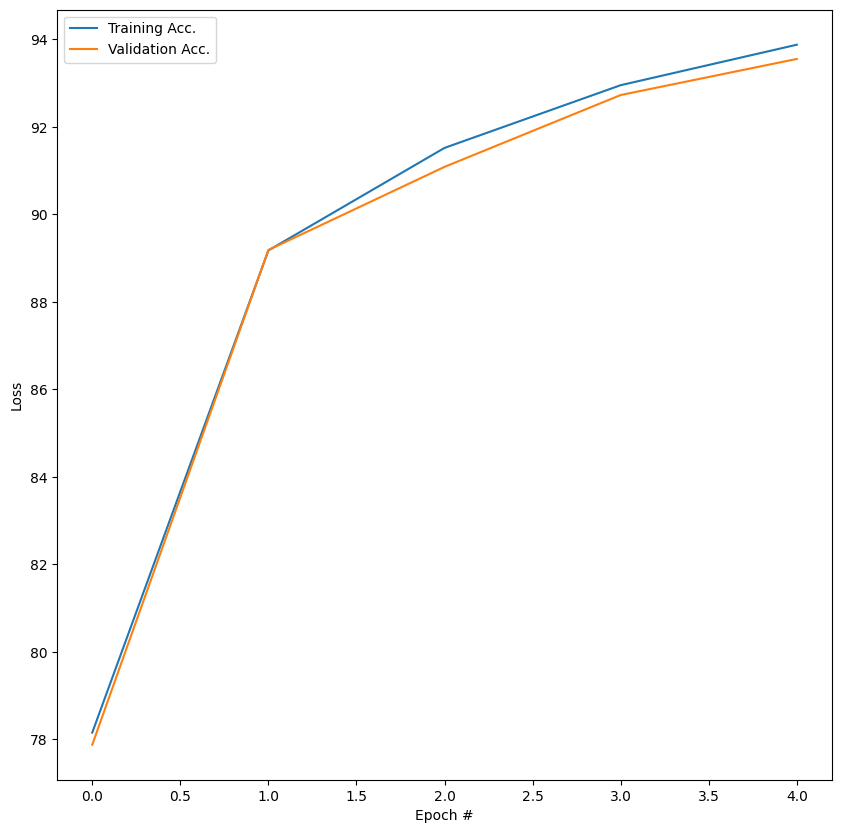

In [39]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


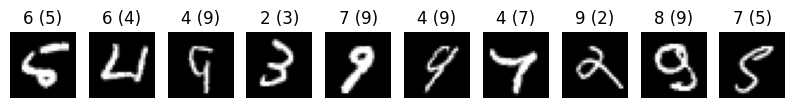

In [41]:
show_failures(nonlinear_model, test_dataloader)

# Recap
To train and validate a neural network model, you need:
- Data split into training/validation/test sets,
- A model with parameters to learn,
- An appropriate loss function,
- An optimizer (with tunable parameters such as learning rate, weight decay etc.) used to learn the parameters of the model.


# Homework

1. Compare the quality of your model when using different:
 - batch sizes,
 - learning rates,
 - activation functions.

3. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization.

__________________________________________________

Non-Linear Model Alpha: Smaller batch size (64); dropout between each layer (10%); 1 ReLu func, 1 Tanh, 1 Sigmoid; smaller learning rate

Comments: The smaller batch size introduces some more randomness to the dropout, as the percentage of dropped neurons will vary more than if there were more items per batch. The increased amount of dropout may introduce more robustness and redundancy to the network, though may take more epochs to do so. The learning rate has been lowered to hopefully maintain stability regardless of the increased gradient variance introduced by the smaller batch size and increased dropout between layers.

In [57]:
#For HW: cell to change batch size
#create dataloader for test data
# The dataloader makes our dataset iterable

batch_size_test = 32

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size_test)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size_test)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)



######


#For HW: cell to change activation
class AlphaNonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(50, 50),
            nn.Sigmoid(),
            nn.Dropout(0.1),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x


######


# For HW: cell to change learning rate
nonlinear_model = AlphaNonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.025)

In [58]:
%%time

epochs = 5
alpha_train_acc_all = []
alpha_val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    alpha_train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    alpha_val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 1.2568194841543834, accuracy: 63.74999999999999
Epoch 0: val. loss: 1.2533064441680908, val. accuracy: 63.949999999999996
Epoch 1: training loss: 0.5962309653957685, accuracy: 85.28958333333333
Epoch 1: val. loss: 0.5962434488137563, val. accuracy: 84.84166666666667
Epoch 2: training loss: 0.3796795575767756, accuracy: 90.18958333333333
Epoch 2: val. loss: 0.3791321387688319, val. accuracy: 89.80833333333334
Epoch 3: training loss: 0.280555637024343, accuracy: 92.525
Epoch 3: val. loss: 0.279745794514815, val. accuracy: 92.15
Epoch 4: training loss: 0.2223757575551669, accuracy: 93.98333333333333
Epoch 4: val. loss: 0.22340800431370736, val. accuracy: 93.58333333333333
CPU times: user 1min 37s, sys: 241 ms, total: 1min 37s
Wall time: 1min 38s


In [59]:
acc_test, loss_test = evaluate(test_dataloader, nonlinear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.2304, test accuracy: 93.40%


Non-Linear Model Beta: Much larger batch size (512); high dropout in one layer (50%); larger learning rate (0.1); all Tanh activation functions

Comments: Larger batch size to offset the high dropout rate; unsure how the robustness will be affected if there is only one layer of dropout. Larger learning rate as a result of higher batch size. Tanh functions to be steeper near 0 than sigmoid or relu.

In [63]:
#For HW: cell to change batch size
#create dataloader for test data
# The dataloader makes our dataset iterable

batch_size_test = 512

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size_test)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size_test)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)



######


#For HW: cell to change activation
class BetaNonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Tanh(),
            #nn.Dropout(0.1),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(50, 50),
            nn.Tanh(),
            #nn.Dropout(0.1),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x


######


# For HW: cell to change learning rate
nonlinear_model = BetaNonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

In [64]:
%%time

epochs = 5
beta_train_acc_all = []
beta_val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    beta_train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    beta_val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 1.1252816522375066, accuracy: 71.11874999999999
Epoch 0: val. loss: 1.1213448892037075, val. accuracy: 71.20833333333333
Epoch 1: training loss: 0.5770873157901967, accuracy: 84.84791666666666
Epoch 1: val. loss: 0.5728103270133337, val. accuracy: 84.81666666666666
Epoch 2: training loss: 0.43993478252532636, accuracy: 87.96666666666667
Epoch 2: val. loss: 0.43257395053903264, val. accuracy: 88.15833333333333
Epoch 3: training loss: 0.37722478014357547, accuracy: 89.3875
Epoch 3: val. loss: 0.3693605239192645, val. accuracy: 89.31666666666666
Epoch 4: training loss: 0.337807316729363, accuracy: 90.33958333333332
Epoch 4: val. loss: 0.33063313737511635, val. accuracy: 90.25
CPU times: user 1min 17s, sys: 187 ms, total: 1min 17s
Wall time: 1min 22s


In [66]:
acc_test, loss_test = evaluate(test_dataloader, nonlinear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.3355, test accuracy: 90.41%


Model Gamma: larger batch size (256); high dropout in first layer, lower in succeeding; higher learning rate (0.05); all sigmoid activation functions

Comments: Compare to model delta, which has the same parameters aside from activation function and switches the high dropout to the last layer.

In [67]:
#For HW: cell to change batch size
#create dataloader for test data
# The dataloader makes our dataset iterable

batch_size_test = 256

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size_test)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size_test)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)



######


#For HW: cell to change activation
class GammaNonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Sigmoid(),
            nn.Dropout(0.30),
            nn.Linear(50, 50),
            nn.Sigmoid(),
            nn.Dropout(0.1),
            nn.Linear(50, 50),
            nn.Sigmoid(),
            nn.Dropout(0.1),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x


######


# For HW: cell to change learning rate
nonlinear_model = GammaNonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

In [68]:
%%time

epochs = 5
gamma_train_acc_all = []
gamma_val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    gamma_train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    gamma_val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 2.3027310028989265, accuracy: 9.966666666666667
Epoch 0: val. loss: 2.302895885832766, val. accuracy: 9.783333333333333
Epoch 1: training loss: 2.302486296663893, accuracy: 17.004166666666666
Epoch 1: val. loss: 2.3026036810367665, val. accuracy: 16.925
Epoch 2: training loss: 2.3024131059646606, accuracy: 9.966666666666667
Epoch 2: val. loss: 2.3025823654012476, val. accuracy: 9.783333333333333
Epoch 3: training loss: 2.3020911838145968, accuracy: 11.2375
Epoch 3: val. loss: 2.302208565651102, val. accuracy: 11.233333333333333
Epoch 4: training loss: 2.301863415444151, accuracy: 11.5
Epoch 4: val. loss: 2.3019102989359106, val. accuracy: 11.600000000000001
CPU times: user 1min 16s, sys: 209 ms, total: 1min 17s
Wall time: 1min 20s


In [69]:
acc_test, loss_test = evaluate(test_dataloader, nonlinear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 2.3016, test accuracy: 11.71%


Model Delta: larger batch size (256); high dropout in last layer, lower in preceding; higher learning rate (0.1); all Tanh activation functions

Comments: Compare to model gamma.

In [71]:
#For HW: cell to change batch size
#create dataloader for test data
# The dataloader makes our dataset iterable

batch_size_test = 256

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size_test)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size_test)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)



######


#For HW: cell to change activation
class DeltaNonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Dropout(0.3),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x


######


# For HW: cell to change learning rate
nonlinear_model = DeltaNonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

In [72]:
%%time

epochs = 5
delta_train_acc_all = []
delta_val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    delta_train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    delta_val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.6502999355818363, accuracy: 82.28541666666666
Epoch 0: val. loss: 0.6450400289068831, val. accuracy: 81.94166666666666
Epoch 1: training loss: 0.3902480209127386, accuracy: 89.1125
Epoch 1: val. loss: 0.38152037656053583, val. accuracy: 89.15833333333333
Epoch 2: training loss: 0.32332565397658247, accuracy: 90.74166666666666
Epoch 2: val. loss: 0.3154574001723148, val. accuracy: 90.525
Epoch 3: training loss: 0.27653018321762696, accuracy: 92.01875000000001
Epoch 3: val. loss: 0.27064996640732947, val. accuracy: 91.875
Epoch 4: training loss: 0.257356630915657, accuracy: 92.43333333333334
Epoch 4: val. loss: 0.25413267377843246, val. accuracy: 92.30000000000001
CPU times: user 1min 18s, sys: 179 ms, total: 1min 18s
Wall time: 1min 21s


In [73]:
acc_test, loss_test = evaluate(test_dataloader, nonlinear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.2562, test accuracy: 92.57%


Model Epsilon: larger batch size (256); low level of dropout in first and last layer; ReLU, sigmoid, tanh
activation functions (arbitrarily, progressively steeper around 0); includes the use of a learning rate scheduler, where the rate starts at 0.1 and is multiplied by 0.85 every epoch

Comments: Hopeful!

In [88]:
#For HW: cell to change batch size
#create dataloader for test data
# The dataloader makes our dataset iterable

batch_size_test = 256

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size_test)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size_test)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)



######


#For HW: cell to change activation
class EpsilonNonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(50, 50),
            nn.Sigmoid(),
            #nn.Dropout(0.15),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x


######



# For HW: cell to change learning rate
nonlinear_model = EpsilonNonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.85)

In [89]:
%%time

epochs = 5
epsilon_train_acc_all = []
epsilon_val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # STEP SCHEDULER FORWARD
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {j}: Learning rate: {current_lr}")

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    epsilon_train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    epsilon_val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: Learning rate: 0.085
Epoch 0: training loss: 2.1902816054668834, accuracy: 44.0
Epoch 0: val. loss: 2.189010696208223, val. accuracy: 44.78333333333334
Epoch 1: Learning rate: 0.07225000000000001
Epoch 1: training loss: 1.0736383649897068, accuracy: 66.33333333333333
Epoch 1: val. loss: 1.0682976613653468, val. accuracy: 66.20833333333334
Epoch 2: Learning rate: 0.06141250000000001
Epoch 2: training loss: 0.7571997709096746, accuracy: 77.82291666666666
Epoch 2: val. loss: 0.7536064665368263, val. accuracy: 77.74166666666666
Epoch 3: Learning rate: 0.05220062500000001
Epoch 3: training loss: 0.6218596018375234, accuracy: 82.03333333333333
Epoch 3: val. loss: 0.6170906893750454, val. accuracy: 81.95833333333333
Epoch 4: Learning rate: 0.044370531250000005
Epoch 4: training loss: 0.546567863289346, accuracy: 84.51458333333333
Epoch 4: val. loss: 0.5419305322018075, val. accuracy: 84.30833333333332
CPU times: user 1min 14s, sys: 155 ms, total: 1min 14s
Wall time: 1min 15s


In [90]:
acc_test, loss_test = evaluate(test_dataloader, nonlinear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.5324, test accuracy: 84.70%


Model Zeta: larger batch size (256); low level of dropout in first and last layer; Progressively flatter activation functions; includes the use of a learning rate scheduler, where the rate starts at 0.1 and is multiplied by 0.85 every TWO epochs

Comments: Compare to epsilon -- reverse activation functions order, and learning rate scheduler reduces only every two epochs

In [91]:
#For HW: cell to change batch size
#create dataloader for test data
# The dataloader makes our dataset iterable

batch_size_test = 256

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size_test)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size_test)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)



######


#For HW: cell to change activation
class ZetaNonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(50, 50),
            nn.Sigmoid(),
            #nn.Dropout(0.15),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x


######



# For HW: cell to change learning rate
nonlinear_model = ZetaNonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.85)

In [92]:
%%time

epochs = 5
zeta_train_acc_all = []
zeta_val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # STEP SCHEDULER FORWARD
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {j}: Learning rate: {current_lr}")

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    zeta_train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    zeta_val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: Learning rate: 0.1
Epoch 0: training loss: 2.236367280178882, accuracy: 41.86666666666667
Epoch 0: val. loss: 2.235656946263415, val. accuracy: 42.583333333333336
Epoch 1: Learning rate: 0.085
Epoch 1: training loss: 1.165104311197362, accuracy: 65.76666666666667
Epoch 1: val. loss: 1.163768707437718, val. accuracy: 65.43333333333334
Epoch 2: Learning rate: 0.085
Epoch 2: training loss: 0.7289594196258707, accuracy: 80.13958333333333
Epoch 2: val. loss: 0.7263843036712484, val. accuracy: 79.94166666666666
Epoch 3: Learning rate: 0.07225000000000001
Epoch 3: training loss: 0.5363546040781001, accuracy: 85.50625
Epoch 3: val. loss: 0.5313660521456536, val. accuracy: 85.5
Epoch 4: Learning rate: 0.07225000000000001
Epoch 4: training loss: 0.46073499860915734, accuracy: 87.44166666666666
Epoch 4: val. loss: 0.453567385039431, val. accuracy: 87.23333333333333
CPU times: user 1min 14s, sys: 159 ms, total: 1min 14s
Wall time: 1min 16s


In [93]:
acc_test, loss_test = evaluate(test_dataloader, nonlinear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.4428, test accuracy: 87.51%


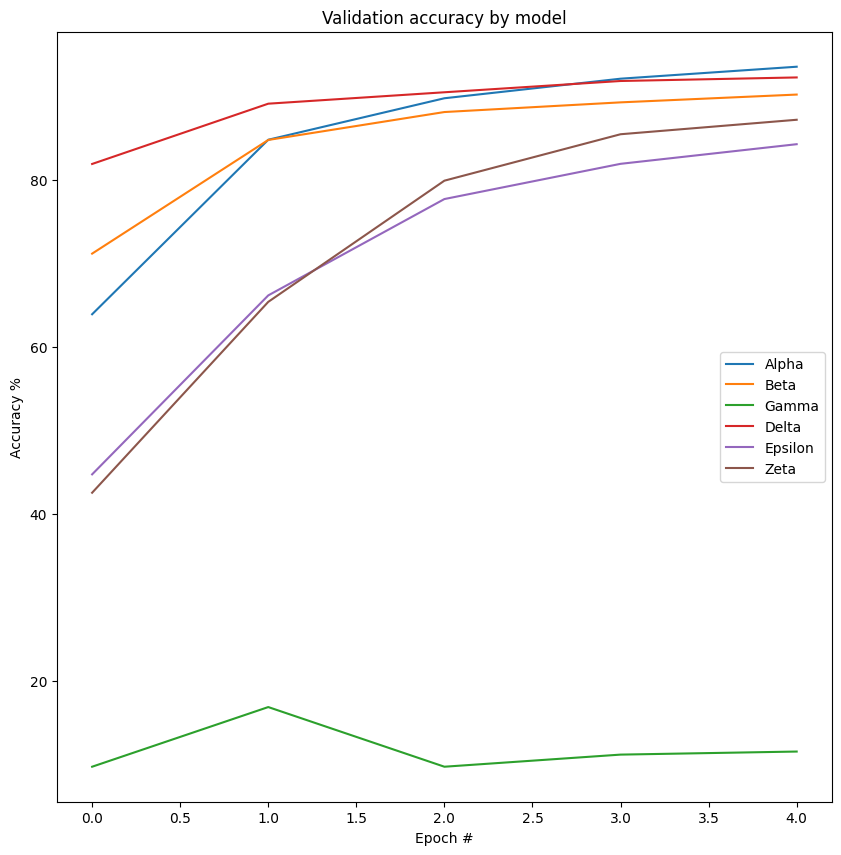

In [94]:
apltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
#plt.plot(range(epochs), alpha_train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), alpha_val_acc_all, label = 'Alpha' )
plt.plot(range(epochs), beta_val_acc_all, label = 'Beta' )
plt.plot(range(epochs), gamma_val_acc_all, label = 'Gamma' )
plt.plot(range(epochs), delta_val_acc_all, label = 'Delta' )
plt.plot(range(epochs), epsilon_val_acc_all, label = 'Epsilon' )
plt.plot(range(epochs), zeta_val_acc_all, label = 'Zeta' )
plt.xlabel('Epoch #')
plt.ylabel('Accuracy %')
plt.title('Validation accuracy by model')
plt.legend()